In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%bash
# Logistics #2: install the transformers package, create a folder, download the dataset and a patch
pip -q install transformers
pip -q install datasets

# remove the directory if necessary
# rm -rf "/content/gdrive/MyDrive/6864_hw4/"

mkdir "/content/drive/My Drive/NLP/"
cd "/content/drive/My Drive/NLP/"

mkdir: cannot create directory ‘/content/drive/My Drive/NLP/’: File exists


In [3]:
import numpy as np
import pandas as pd
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
project_path = '/content/drive/My Drive/NLP/'

from datasets import load_dataset

dataset = load_dataset('liar')
dataset
# print([a for a in dataset['train'] if a['label'] == 5][0])


Using custom data configuration default


Dataset liar downloaded and prepared to /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})

In [5]:
def bin_labels(dataset):
  mapping = {
      0: 'false',
      1: 'half-true',
      2: 'mostly-true',
      3: 'true',
      4: 'barely-true',
      5: 'pants-fire'
  }
  texts = np.array(dataset['statement'])
  labels = np.array(dataset['label'])
  true = labels == 3
  mostly_true = labels == 2
  pos_labels = np.logical_or(true, mostly_true)
  labels = np.where(pos_labels, 1, 0)

  new_dataset = pd.DataFrame()
  new_dataset['text'] = texts
  new_dataset['label'] = labels
  return new_dataset

data_train = bin_labels(dataset['train'])
data_val = bin_labels(dataset['validation'])
data_test = bin_labels(dataset['test'])
  
  

In [6]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer('hello world')

{'input_ids': [101, 7592, 2088, 102], 'attention_mask': [1, 1, 1, 1]}

In [7]:
import torch.nn as nn

class FakeNewsClassifier(nn.Module):
  def __init__(self, lm):
    super(FakeNewsClassifier, self).__init__()
    self.lm = lm
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask=None):
    lm_output = self.lm(input_ids, attention_mask)
    logits = lm_output.logits
    pred = self.sigmoid(logits)
    return pred
  


In [8]:
#distilbert = transformers.AutoModel.from_pretrained('distilbert-base-uncased')
config = transformers.DistilBertConfig(num_labels=1)
distilbert = transformers.DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)
model = FakeNewsClassifier(distilbert)
if torch.cuda.is_available():
  model = model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

In [9]:
def tokenize_batch_farn(batch):
  x = list(batch['text'])
  y = np.array(batch['label'])
  
  x_encode = tokenizer.batch_encode_plus(
      x,
      max_length=512,
      truncation=True,
      padding='longest',
      return_attention_mask=True,
      return_tensors='pt'
  )
  if torch.cuda.is_available():
    input_ids = x_encode['input_ids'].cuda()
    input_mask = x_encode['attention_mask'].cuda()
  else:
    input_ids, input_mask = x_encode['input_ids'], x_encode['attention_mask']

  return input_ids, input_mask, y

In [10]:

training_size = len(data_train)
validation_size = len(data_val)
testing_size = len(data_test)

# data_train = dataset[:training_size]
# data_val = dataset[training_size:training_size+validation_size]
# data_test = dataset[training_size+validation_size:]

print(len(data_train))
print(data_train['label'].sum() / len(data_train))
print(len(data_val))
print(data_val['label'].sum() / len(data_val))
print(len(data_test))
print(data_test['label'].sum() / len(data_test))


10269
0.3553413185315026
1284
0.32710280373831774
1283
0.35853468433359315


In [11]:
def decode(pred):
  decoded = torch.where(pred >= 0.5, 1, 0)
  return decoded

def get_acc(preds, labels):
  decoded = decode(preds).to(dtype=torch.float32)
  acc = torch.where(decoded == labels, 1, 0)
  return acc.sum()


Loss: 0.5688978433609009
Val acc: 0.690809968847352
Loss: 0.3898293972015381
Val acc: 0.6799065420560748
Loss: 0.5647192597389221
Val acc: 0.6277258566978193
Loss: 0.5090569257736206
Val acc: 0.6292834890965732
Loss: 0.40869632363319397
Val acc: 0.6736760124610592
Loss: 0.6847363114356995
Val acc: 0.6806853582554517
Loss: 0.37580421566963196
Val acc: 0.6876947040498442
Loss: 0.30565381050109863
Val acc: 0.677570093457944
Loss: 0.43091505765914917
Val acc: 0.6012461059190031
Loss: 0.529207170009613
Val acc: 0.588006230529595
Loss: 0.3535800278186798
Val acc: 0.6588785046728972
Loss: 0.4953405261039734
Val acc: 0.6456386292834891
Loss: 0.21927736699581146
Val acc: 0.632398753894081
Loss: 0.24381718039512634
Val acc: 0.6962616822429907
Loss: 0.2988198697566986
Val acc: 0.6160436137071651
Loss: 0.10257820785045624
Val acc: 0.6238317757009346
Loss: 0.3033309578895569
Val acc: 0.6300623052959502
Loss: 0.3856455981731415
Val acc: 0.6440809968847352
Loss: 0.07427022606134415
Val acc: 0.6682242

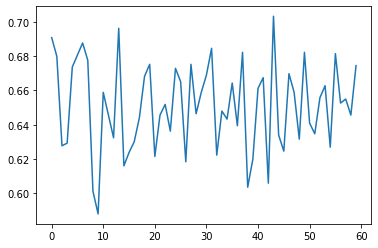

In [ ]:

import matplotlib.pyplot as plt

num_epochs = 10
learning_rate = 3e-5
weight_decay = 1e-5
eps = 1e-6
batch_size = 16
warmup_rate = 0.05

# Initializing an AdamW optimizer
ext_optim = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                              eps=eps, weight_decay=weight_decay)

loss_fn = nn.BCELoss()

model.train()

val_accuracies = []
for _ in range(num_epochs):
  for i in range(0, len(data_train), batch_size):
    batch = data_train[i : i + batch_size]
    input_ids, input_mask, labels = tokenize_batch_farn(batch)
    labels = torch.tensor(labels).unsqueeze(-1).to(dtype=torch.float32).cuda()

    model.zero_grad()
    predictions = model(input_ids, input_mask)
    predictions.to(torch.float32)

    loss = loss_fn(predictions, labels)
    loss.backward()

    ext_optim.step()

    if i % 1000 == 0:
      total_val_acc = 0
      val_batch_size = 16
      for i in range(0, len(data_val), val_batch_size):
        input_ids, input_mask, labels = tokenize_batch_farn(data_val[i : i+val_batch_size])
        labels = torch.tensor(labels).unsqueeze(-1).to(dtype=torch.float32).cuda()
        preds = model.forward(input_ids, input_mask)
        decoded = decode(preds).to(dtype=torch.float32)
        acc = get_acc(decoded, labels)
        total_val_acc += acc
      total_val_acc = int(total_val_acc) / len(data_val)
      val_accuracies.append(total_val_acc)

      print("Loss: {}".format(loss))
      print("Val acc: {}".format(total_val_acc))

plt.plot(val_accuracies)
plt.show()

torch.save(model.state_dict(), project_path+'distilbert/model_embed_liar.pt')




In [13]:
model.load_state_dict(torch.load(project_path + "distilbert/model_embed_liar.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
# def decode(pred):
#   decoded = torch.where(pred >= 0.5, 1, 0)
#   return decoded

test_sample = data_test

results = []
labels_ = []
total_acc = 0
test_batch_size = 1
misclassified_indices = []
for i in range(0, len(test_sample), test_batch_size):

  input_ids, input_mask, labels = tokenize_batch_farn(test_sample[i : i+test_batch_size])
  labels = torch.tensor(labels).unsqueeze(-1).to(dtype=torch.float32)
  if torch.cuda.is_available():
    labels = labels.cuda()

  preds = model.forward(input_ids, input_mask)
  decoded = decode(preds).to(dtype=torch.float32)
  # print(decoded)
  # print(labels)
  if (decoded != labels).item():
    misclassified_indices.append(i)
  # if decoded
  # misclassified_indices.extend(torch.where((decoded != labels)).tolist())
  results.append(decoded)
  labels_.append(labels)
  acc = torch.where(decoded == labels, 1, 0)
  total_acc += acc.sum()
  # break

print(int(total_acc) / len(test_sample))


0.6297739672642245


In [15]:

results = torch.cat(results).cpu()

labels = torch.cat(labels_).cpu()

print(results.shape, labels.shape)
results = results.reshape(-1)
labels = labels.reshape(-1)
print(results.shape, labels.shape)

from sklearn.metrics import precision_score, recall_score, f1_score

# accuracy = (results == labels).sum() / len(labels)

prec = precision_score(labels, results)
recall = recall_score(labels, results)
f1 = f1_score(labels, results)

print(acc, prec, recall, f1)

# true_pos = torch.logical_and([results, labels])
# false_pos = torch.logical_and([results, torch.logical_not(labels)])
# false_neg = torch.logical_and([labels, torch.logical_not(results)])

# precision = true_pos.sum() / (true_pos.sum() + false_pos.sum())
# recall = true_pos.sum() / (true_pos.sum() + false_neg.sum())

torch.Size([1283, 1]) torch.Size([1283, 1])
torch.Size([1283]) torch.Size([1283])
tensor([[1]], device='cuda:0') 0.48532289628180036 0.5391304347826087 0.5108135942327497


In [ ]:
df_test = pd.DataFrame(index=range(len(data_test)))
for feature in dataset['test'].features:
  # print(len(dataset['train'][feature]))
  df_test[feature] = dataset['test'][feature]
df_test

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,11972.json,3,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30.0,30.0,42.0,23.0,18.0,Radio interview
1,11685.json,0,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2.0,1.0,0.0,0.0,0.0,a news conference
2,11096.json,0,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,comments on ABC's This Week.
3,5209.json,1,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1.0,1.0,3.0,1.0,1.0,a radio show
4,9524.json,5,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,,Wisconsin,democrat,5.0,7.0,2.0,2.0,7.0,a web video
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,7334.json,1,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28.0,23.0,38.0,34.0,7.0,a news conference
1279,9788.json,4,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2.0,0.0,0.0,1.0,0.0,"on ABC's ""This Week"""
1280,10710.json,4,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1.0,0.0,0.0,0.0,0.0,a commentary in The Providence Journal
1281,3186.json,4,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,republican,9.0,8.0,10.0,18.0,3.0,a news conference


In [ ]:
pd.set_option("max_colwidth", 200)
df_test.iloc[misclassified_indices]['speaker'].value_counts()

barack-obama                    28
hillary-clinton                 12
john-mccain                     10
rick-scott                       9
donald-trump                     8
                                ..
bob-terry                        1
eric-bolling                     1
america-rising-now               1
paul-saldana                     1
childrens-healthcare-atlanta     1
Name: speaker, Length: 312, dtype: int64

In [ ]:
real = data_test['label'] == 1
fake = data_test['label'] == 0
classified = list(set(range(1283)) - set(misclassified_indices))

In [ ]:
for indices in [classified, misclassified_indices]:
  for t in [real, fake]:
    display(pd.DataFrame(df_test.iloc[indices].loc[t]['context'].value_counts()).head(10))


,context
a press release,11
a speech,10
an interview,7
a news conference,5
a tweet,4
"an interview on NBC's ""Meet the Press""",3
an opinion column,3
the State of the Union address,3
a TV ad,3
a news release,3


,context
a news release,17
a television ad,16
a TV ad,12
a tweet,11
a press release,11
an interview,11
a campaign ad,8
a campaign commercial,7
a TV ad.,6
a Facebook post,6


,context
a speech,7
,6
an interview,6
a TV ad,5
a press release,4
a television ad,3
a news conference,3
a campaign commercial,3
"comments on ""Fox News Sunday""",3
a TV interview,2


,context
a news release,12
an interview,8
a press release,5
,4
a TV interview,4
a speech,4
a TV interview.,3
a TV ad,3
a debate,3
"an interview on NBC's ""Meet the Press""",3


In [ ]:
def serialize_subjects(df):
  serialized_subjects = [s.split(",") for s in df['subject'].tolist()]
  list_subjects = []
  for s in serialized_subjects:
    list_subjects.extend(s)
  return pd.DataFrame(list_subjects, columns=['subject'])

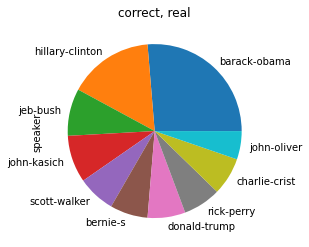

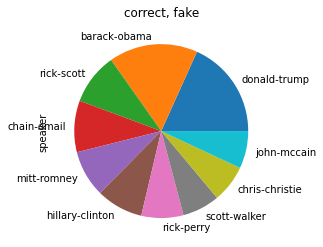

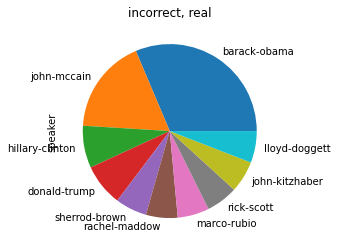

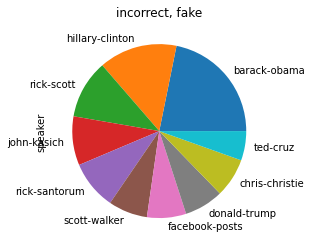

In [ ]:
import matplotlib.pyplot as plt
def make_pie_charts(feature):
  indices = [classified, misclassified_indices]
  real_or_fake = [real, fake]
  indices_dict = {0: 'correct', 1: 'incorrect'}
  real_dict = {0: 'real', 1: 'fake'}
  for i in range(2):
    for j in range(2):
      df = df_test.iloc[indices[i]].loc[real_or_fake[j]]
      if feature == 'subject':
        display(serialize_subjects(df)[feature].value_counts().head(10).plot.pie(y='subject', title=f'{indices_dict[i]}, {real_dict[j]}'))
      else:
        display(df[feature].value_counts().head(10).plot.pie(y='job title', title=f'{indices_dict[i]}, {real_dict[j]}'))
      plt.show()
      # display(pd.DataFrame(df_test.iloc[indices].loc[t]['context'].value_counts()).head(10))
make_pie_charts('speaker')